
# CS-E4895: Gaussian Processes

# Assignment #6: Bayesian optimization, and GPLVM

### Learning objectives

After completing the exercise, you should be able to:

- Implement an acquisition function and study its properties
- Use the acquisition function to implement Bayesian optimization
- Gaussian process latent variable model, Principal component analysis, Bayesian Gaussian process latent variable model 


## Enter your student number here

**STUDENT_NUMBER** = XXX

## Warnings:

- Don’t copy and paste cells within a notebook. This will mess up the tracking metadata and prevent autograding from working.
- Only add new cells using the '+' button in the upper toolbar and do not split cells.
- Be cautious about things such as copying the whole notebook to Colab to work on it. This has sometimes resulted in removing all notebook metadata, making autograding impossible.

In [4]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import seaborn as snb
import pandas as pd
from sklearn.decomposition import PCA
import gpflow
import tensorflow as tf
snb.set(font_scale=1.5)

import IPython
assert IPython.version_info[0] >= 3, "Your version of IPython is too old, please update it."

In [5]:
automatic_grading = False  # Set this to True after completing the notebook and before submitting.

#### Do not move or delete the below block. It is used for automatic grading.

### Task 1: Acquisition Function (2.5 points)

**Task 1a:** Code up a GP class, which we need for Bayesian optimization. For the kernel, we use an Squared Exponential kernel. 

In [12]:
class GP():
    """
    Class for a GP model
    """
    def __init__(self, data, sigma2, length_scale=1., variance=1.):
        """
        Initialize your GP class.
        Parameters
        ----------
        data : Tuple of regression data input and observation e.g. (X, y).
        sigma2 : likelihood variance with dtype float.
        length_scale: Kernel lengthscale with dtype float.
        variance: Kernel variance with dtype float.
        """
        self.data = data
        self.sigma2 = sigma2
        self.length_scale = length_scale
        self.variance = variance
       

    def kernel(self, X1, X2):
        """
        Return the kernel matrix K.
        
        Parameters
        ----------
        X1 : ndarray of shape (N, 1)
        X2 : ndarray of shape (M, 1)
        Returns
        -------
        K : ndarray of shape (N, M)
        """
        # YOUR CODE HERE
        
        sqdist = np.sum(X1**2, axis=1, keepdims=True) - 2*np.dot(X1, X2.T) + np.sum(X2**2, axis=1)
        K = self.variance * np.exp(-0.5 * sqdist / self.length_scale**2)
        return K
    
        #raise NotImplementedError()


    def predict_f(self, x_new):
        """
        Return the mean and marginal variance of GP model.
        
        Parameters
        ----------
        x_new : ndarray of shape (P, 1)
        
        Returns
        -------
        m : ndarray of shape (P, 1)
        v : ndarray of shape (P, 1)
        """
        # YOUR CODE HERE
        
        X, y = self.data
        K = self.kernel(X, X)  
        K += self.sigma2 * np.eye(K.shape[0])  
        K_s = self.kernel(X, x_new)       
        K_ss = self.kernel(x_new, x_new)       

        L = np.linalg.cholesky(K)  


        z = np.linalg.solve(L,y)

        alpha = np.linalg.solve(L.T, z)

        m = np.dot(K_s.T, alpha)

        v_temp = np.linalg.solve(L, K_s)
        
        pred_var = np.diag(K_ss) - np.sum(v_temp**2, axis=0)
        
        m = m.reshape(-1, 1)
        pred_var = pred_var.reshape(-1, 1)
        
        return m, pred_var
    
        #raise NotImplementedError()


Let's test the above function:

In [13]:
test_x = 2 * np.ones((2, 1))
test_y = .45 * np.ones((2, 1))

test_gp_model = GP(data=(test_x, test_y), sigma2=0.23, length_scale=0.5, variance=0.2)

# Test Kernel 
test_X1 = 1.46 * np.ones((2, 1))
test_X2 = 0.52 * np.ones((3, 1))
test_kernel_val = test_gp_model.kernel(test_X1, test_X2)
expected_kernel_val = np.array([
        [0.0342, 0.0342, 0.0342],
        [0.0342, 0.0342, 0.0342]
    ])
assert test_kernel_val.shape == (2, 3)
np.testing.assert_allclose(expected_kernel_val, test_kernel_val, rtol=1e-3, atol=1e-3)

# Test predict_f
test_m, test_S = test_gp_model.predict_f(test_X2)
assert test_m.shape == (3, 1)
assert test_S.shape == (3, 1)
expected_m = np.array([[0.00357581], [0.00357581], [0.00357581]])
expected_S = np.array([[0.19998011], [0.19998011], [0.19998011]])
np.testing.assert_allclose(expected_m, test_m, rtol=1e-3, atol=1e-3)
np.testing.assert_allclose(expected_S, test_S, rtol=1e-3, atol=1e-3)

#### Do not move or delete the below two blocks. It is used for automatic grading.

**Task 1b)** Implement the UCB acquisiton function.

In [14]:
def UCB(mean, std, beta=1.0):
    """
    Implement the UCB acquisition function.

    mean: np.ndarray of shape (N, 1)
    std: np.ndarray of shape (N, 1)
    beta: float value.

    return: np.ndarray of shape (N, 1)
    """
    # YOUR CODE HERE
    return mean + beta * std
    #raise NotImplementedError()

Let's test the above function:

In [15]:
test_mean = 1.2 * np.ones((5, 1))
test_std = .5 * np.ones((5, 1))
test_beta = 0.3

test_ucb_val = UCB(test_mean, test_std, beta=test_beta)
expected_ucb_val = np.array([[1.35], [1.35], [1.35], [1.35],[1.35]])
assert test_ucb_val.shape == (5, 1)
np.testing.assert_allclose(test_ucb_val, expected_ucb_val, atol=1e-5)

#### Do not move or delete the below two blocks. It is used for automatic grading.

Next, we define a multi-modal function that we are going to use to see the samples from the UCB acquisiton function.

In [16]:
N_data = 2

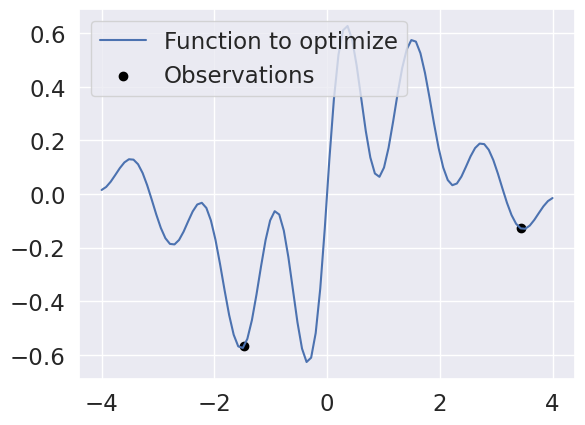

In [17]:
def multimodal_func_1(x):
    return 5 * (1.5*np.sin(x) + np.sin(5 * x)) * 0.1*np.exp(-np.abs(0.5*x))

# Create grid and sample some observations from the function between [-4, 4]
N = 100
X = np.linspace(-4,4,N)[..., None]
np.random.seed(12345)
X_data = np.random.uniform(-4, 4, N_data)[..., None]
Y_data = multimodal_func_1(X_data)

# Plotting 
plt.plot(X, multimodal_func_1(X), label="Function to optimize")
plt.scatter(X_data, Y_data, color="black", label="Observations")
plt.legend()
plt.show()

**Task 1c)** Complete the function below to condition the GP on the `(X_train, Y_train)` and return the posterior for the `X`.

In [25]:
def get_gp_posterior(X_train, Y_train, X, kernel_lengthscale, kernel_variance, sigma2):
    """
    Condition a GP on the data, (X_train, Y_train) using the RBF kernel with the parameters passed to the function.

    return the prediction posterior i.e. posterior mean and posterior variance

    args: 
    
    X_train of shape (N, 1)
    Y_train of shape (N, 1)
    X of shape (P, 1)
    lengthscale, variance, and sigma2 are floats.

    return posterior mean and posterior variance of the shape (N, 1)
    """
    # YOUR CODE HERE
    
    
    gp_model = GP((X_train, Y_train), sigma2, length_scale=kernel_lengthscale, variance=kernel_variance)
    
    post_means, post_vars = gp_model.predict_f(X)
    #raise NotImplementedError()
    return post_means, post_vars
    

Let's test the above function:

In [26]:
X_train_test = np.ones((2, 1))
Y_train_test = np.zeros((2, 1))
X_test = 1.2 * np.ones((3, 1))

test_post_m, test_post_S = get_gp_posterior(X_train_test, Y_train_test, X_test, 
                                            0.5, 0.6, 0.003)

assert test_post_m.shape == (3, 1)
assert test_post_S.shape == (3, 1)

np.testing.assert_allclose(test_post_m, -6.1235974e-06 * np.ones_like(test_post_m))
np.testing.assert_allclose(test_post_S, 0.6 * np.ones_like(test_post_S))

AssertionError: 
Not equal to tolerance rtol=1e-07, atol=0

Mismatched elements: 3 / 3 (100%)
Max absolute difference: 6.1235974e-06
Max relative difference: 1.
 x: array([[0.],
       [0.],
       [0.]])
 y: array([[-6.123597e-06],
       [-6.123597e-06],
       [-6.123597e-06]])

#### Do not move or delete the below block. It is used for automatic grading.

Next, we plot the acquisiton function evaluated on our initial dataset. 

In [ ]:
def plot_posterior(X_data, Y_data, X):
    post_means, post_vars = get_gp_posterior(X_data, Y_data, X, 0.4, 0.5, 0.0001)
    
    # Plotting
    plt.plot(X, multimodal_func_1(X), "blue")
    plt.scatter(X_data, Y_data, s=45, color="black")
    plt.plot(X, post_means, c='green')
    plt.fill_between(X.squeeze(), (post_means + np.sqrt(post_vars)).reshape((-1,)), 
                     (post_means - np.sqrt(post_vars)).reshape((-1,)), alpha=0.2, 
                     color='green')
    plt.legend(["Original function", "Observed data", "GP posterior"])
    plt.show()

plot_posterior(X_data, Y_data, X)

**Task 1d** Plot the acquisition function with different values of beta variable in UCB.

In [ ]:
beta_vals = [0.1, 0.4, 0.8, 1.0, 1.5]
kernel_lengthscale = 0.4
kernel_variance = 0.5 
sigma2 = 0.0001

# YOUR CODE HERE
raise NotImplementedError()

plt.scatter(X_data, Y_data, s=45, color="black")
plt.legend()
plt.show()

**Task 1e)** What does the beta parameter in the UCB acquisition function handle?

1) Feature selection
2) Regularization
3) Exploration and exploitation
4) Sampling and accuracy

In [ ]:
a_1e = None  # Replace with the answer: 1, 2, 3, 4

In [ ]:
assert a_1e in [1, 2, 3, 4]

#### Do not move or delete the below block. It is used for automatic grading.

**Extra Task (No points):** Increase the number of data points and plot the posterior along with the samples from the UCB acquisition function. What difference do you see?

### Task 2: Bayesian Optimization (1.5 points)

First, we define the function (Gramacy & Lee), which is the true function and will be used to simulate and get the observations. 

In [ ]:
def gramacy_lee(x):
    """
    The Gramacy & Lee function, typically evaluated over :math:`[0.5, 2.5]`.
    
    :param x: Where to evaluate the function, with shape [N, 1].
    :return: The function values, with shape [N, 1].
    """
    return -(np.sin(10 * np.pi * x) / (2 * x) + (x - 1) ** 4)

In [ ]:
x_bo = np.linspace(0.5, 2.5, 100)[:, None]
y_bo = gramacy_lee(x_bo)

plt.plot(x_bo, y_bo)
plt.show()

Next, we write the Bayesian optimizatoon loop.

**Task 2a)** Complete the below function.

In [ ]:
def bayes_optimization(x_bo, sigma2=0.0001, length_scale=0.1, variance=2, n_steps=10):
    """A Bayesian optimization loop.

    x_bo: X range for the function.
    sigma2: Likelihood variance
    length_scale: Kernel length scale.
    variance: Kernel variance.
    n_steps: Bayesian optimization steps to take.
    
    Returns:
    X_obs: An array of length N_obs_total, containing the chosen X points in order
    Y_obs: An array of length N_obs_total, containing the function values corresponding to X_obs
    """
    X_obs = np.array([2]) # Starting guess, this can be changed
    Y_obs = gramacy_lee(X_obs)

    for i in range(n_steps):
        # YOUR CODE HERE
        raise NotImplementedError()
    return X_obs, Y_obs


Let's test the function.

In [ ]:
x_bo_test = np.array([1, 2, 3])[..., None]
x_test_obs, y_test_obs = bayes_optimization(x_bo_test, sigma2=.2, length_scale=.4, 
                                            variance=.7, n_steps=1)
np.testing.assert_almost_equal(x_test_obs, np.array([2, 1]))
np.testing.assert_almost_equal(y_test_obs, np.array([-1, 6.123234e-16]))

#### Do not move or delete the below block. It is used for automatic grading.

Next, we plot the BO results.

Below plotting code is complete. However, you can play with the hyperparameter values to see their impact. 

In [ ]:
def plot_bo_results(X_obs, Y_obs, x_bo, sigma2=0.0001, length_scale=0.1, variance=2):
    fig, ax = plt.subplots(2, 5, figsize=(24, 10))
    for i in range(1, 11):
        x_ = (i-1) % 5
        y_ = (i-1) // 5
        post_means, post_vars = GP((X_obs[:i, None], Y_obs[:i, None]), 
                               sigma2, length_scale, variance).predict_f(x_bo)
        post_means, post_vars = post_means.squeeze(), post_vars.squeeze()
        
        ax[y_,x_].plot(X_obs[:i], Y_obs[:i], 'o')
        ax[y_,x_].plot(x_bo, y_bo)
        ax[y_,x_].plot(x_bo, post_means)
        ax[y_,x_].fill_between(x_bo.squeeze(), post_means + np.sqrt(post_vars), post_means - np.sqrt(post_vars), alpha=0.2)
        ax[y_,x_].plot(x_bo, UCB(post_means, np.sqrt(post_vars)))
        ax[y_,x_].set_title(f"{i} iteration")

    plt.show()

In [ ]:
sigma2 = 0.01
length_scale = 0.1
variance = 2
X_obs, Y_obs = bayes_optimization(x_bo, sigma2, length_scale, variance, n_steps=10)
plot_bo_results(X_obs, Y_obs, x_bo, sigma2, length_scale, variance)

Regret plots are common way to visualise and show how the BO loop performs against some maximum/minimum.

You can choose the number of iterations but we suggest perhaps only a few initial points.

In [ ]:
gramacy_lee_max = 0.548562  # We know the ground truth value

In [ ]:
def format_point_markers(
    num_pts,
    num_init,
    idx_best=None,
    mask_fail=None,
    m_init="x",
    m_add="circle",
    c_pass="green",
    c_fail="red",
    c_best="darkmagenta",
):
    """
    Prepares point marker styles according to some BO factors
    :param num_pts: total number of BO points
    :param num_init: initial number of BO points
    :param idx_best: index of the best BO point
    :param mask_fail: Boolean vector, True if the corresponding observation violates the constraint(s)
    :param m_init: marker for the initial BO points
    :param m_add: marker for the other BO points
    :param c_pass: color for the regular BO points
    :param c_fail: color for the failed BO points
    :param c_best: color for the best BO points
    :return: 2 string vectors col_pts, mark_pts containing marker styles and colors
    """

    col_pts = np.repeat(c_pass, num_pts).astype("<U15")
    mark_pts = np.repeat(m_init, num_pts).astype("<U15")
    mark_pts[num_init:] = m_add
    if mask_fail is not None:
        col_pts[mask_fail] = c_fail
    if idx_best is not None:
        col_pts[idx_best] = c_best

    return col_pts, mark_pts

def plot_regret(
    obs_values,
    ax,
    show_obs=True,
    num_init=None,
    mask_fail=None,
    idx_best=None,
    m_init="x",
    m_add="o",
    c_pass="tab:green",
    c_fail="tab:red",
    c_best="tab:purple",
):
    """
    Draws the simple regret
    :param obs_values:
    :param ax:
    :param show_obs:
    :param num_init:
    :param mask_fail:
    :param idx_best:
    :param m_init:
    :param m_add:
    :param c_pass:
    :param c_fail:
    :param c_best:
    :return:
    """

    col_pts, mark_pts = format_point_markers(
        obs_values.shape[0], num_init, idx_best, mask_fail, m_init, m_add, c_pass, c_fail, c_best
    )

    safe_obs_values = obs_values.copy()
    if mask_fail is not None:
        safe_obs_values[mask_fail] = np.max(obs_values)

    ax.plot(np.minimum.accumulate(safe_obs_values), color="tab:orange")

    if show_obs:
        for i in range(obs_values.shape[0]):
            ax.scatter(i, obs_values[i], c=col_pts[i], marker=mark_pts[i])

    ax.axvline(x=num_init - 0.5, color="tab:blue")

Now, we plot the regret for UCB acquisition function. Feel free to play with the hyperparameter values to see their impact. 

In [ ]:
sigma2 = 0.01
length_scale = 0.1
variance = 2

X_obs, Y_obs = bayes_optimization(x_bo, sigma2=sigma2, length_scale=length_scale, variance=variance, n_steps=10)
suboptimality = gramacy_lee_max - Y_obs

plot_regret(suboptimality, plt, num_init=len(X_obs), idx_best=np.argmax(Y_obs))

plt.title("Regret Plot")
plt.show()

**Task 2b:** From the plots above, what does the regret plot illustrate?

1. The expected improvement in performance achieved by selecting optimal parameters.
2. The trade-off between exploration and exploitation during the optimization process.
3. The cumulative difference between the performance of the best observed point and the true optimum over time.
4. The distribution of samples across the search space during the optimization.

In [ ]:
a_2b = None # Replace None with your answer [1, 2, 3, 4]

In [ ]:
assert a_2b in [1, 2, 3, 4]

#### Do not move or delete the below block. It is used for automatic grading.

### Task 3: Gaussian process latent variable model (2 points)

The GPLVM is a non-linear, kernelized, probabilistic variant of PCA. We start from input datapoints $\mathbf{x} \in \mathbb{R}^D$ in a real-valued space $\mathbb{R}^D$. Our goal is to find the embedding $\mathbf{z} \in \mathbb{R}^Q$ for each datapoint $\mathbf{x}$, where $Q < D$. The GPLVM was described in lecture 7. 

The key idea of GPLVM is to model the mapping from latent space to data space as a GP,
\begin{align}
\mathbf{x}(\mathbf{z}) \sim \mathcal{GP}(m(\mathbf{z}), k( \mathbf{z}, \mathbf{z}')),
\end{align}
where each dimension $d = 1,\ldots,D$ has its own univariate-output GP.

The GPLVM has two main learning targets. In conventional GPLVM we optimize point estimates for $\mathbf{Z},\theta$ by maximum likelihood
\begin{align}
\mathrm{maximize} \quad \log p(\mathbf{X} | \mathbf{Z}, \theta) \propto -D/2 \log | \mathbf{K}_{ZZ}| - 1/2 tr( \mathbf{K}_{ZZ}^{-1} \mathbf{X} \mathbf{X}^T),
\end{align}
or by MAP
\begin{align}
\mathrm{maximize} \quad \log p(\mathbf{X} | \mathbf{Z}, \theta) + \log p(\mathbf{Z}). 
\end{align}

Finally, the Bayesian GPLVM is a model where we also aim to marginalize the distribution of latent variables and infer the variational posterior $q(\mathbf{Z})$ of the latent variables. This is useful since it gives an uncertainty (eg. $\mathrm{var}[q(\mathbf{Z})]$) for the embeddings.

In this task you compare PCA, GPLVM and Bayesian GPLVM on "oilflow" dataset https://inverseprobability.com/3PhaseData. The dataset contains 1000 datapoints with 12 covariates, and are labelled into three categories. If you run into computational problems, you can use a subset of the data.

You can use any GPLVM implementation available online. For this task, we recommend gpflow (tensorflow-based) because that's what we have tested on, but GPyTorch (torch-based) would likely be good as well. Both frameworks have helpful documentation and examples: See:
- https://gpflow.github.io/GPflow/2.7.1/index.html
- https://nbviewer.org/github/GPflow/GPflow/blob/develop-1.0/doc/source/notebooks/intro.ipynb?flush_cache=true. 


In [ ]:
# We start by loading the data
data = pd.read_csv("DataTrn.txt", header=None, sep='\s+')[:1000]
data.head()

In [ ]:
data.plot(0,2,'scatter')

**Task 3a:** Perform PCA and visualise the data using two principal components

In [ ]:
pca_transformed_data = None  # Update this
# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
assert isinstance(pca_transformed_data, np.ndarray)
assert pca_transformed_data.shape == (data.shape[0], 2)

In [ ]:
plt.plot(pca_transformed_data[:,0], pca_transformed_data[:,1], 'o')
plt.show()

#### Do not move or delete the below block. It is used for automatic grading.

**Task 3b:** Perform GPLVM and visualise the latent embedding. Can you see any differences to PCA. Can you explain why?

In [ ]:
if not automatic_grading:  # Note: Do not change this if condition
    latent_dim = 2
    lengthscales = tf.convert_to_tensor([1.0] * latent_dim)
    kernel = gpflow.kernels.RBF(lengthscales=lengthscales)
    # YOUR CODE HERE
    raise NotImplementedError()

**Task 3c:** Which of the following statements accurately distinguishes between Principal Component Analysis (PCA) and Gaussian Process Latent Variable Models (GPLVM)?

1. PCA is a linear dimensionality reduction technique, while GPLVM is a nonlinear method.

2. GPLVM is an unsupervised learning technique, while PCA can be used for both supervised and unsupervised learning tasks.

3. PCA assumes that the principal components with the highest variance capture the most important information in the data, whereas GPLVM makes fewer assumptions about the underlying data structure.

4. GPLVM is primarily used for data visualization and noise reduction, while PCA is suitable for capturing complex, nonlinear relationships in the data.

In [ ]:
a_3c = None  # Replace None with your answer [1, 2, 3, 4]

In [ ]:
assert a_3c in [1, 2, 3, 4]

#### Do not move or delete the below block. It is used for automatic grading.

**Task 3d:** Perform Bayesian GPLVM and visualise the embeddings as Gaussians (i.e. by plotting 95% contours).

In [ ]:
if not automatic_grading:  # Note: Do not change this if condition
    num_inducing = 20  # number of inducing points
    num_data = data.shape[0]  # number of data points
    latent_dim = 2
    lengthscales = tf.convert_to_tensor([1.0] * latent_dim)
    kernel = gpflow.kernels.RBF(lengthscales=lengthscales)
    
    # YOUR CODE HERE
    raise NotImplementedError()

***Task 3e.*** Which statement accurately differentiates between Gaussian Process Latent Variable Models (GPLVM) and Bayesian Gaussian Process Latent Variable Models (Bayesian GPLVM)?

1. GPLVM is a probabilistic model, while Bayesian GPLVM is deterministic.

2. Bayesian GPLVM allows for the incorporation of prior knowledge about the latent space, whereas GPLVM does not consider prior information.

3. GPLVM assumes linear relationships between variables, while Bayesian GPLVM captures nonlinear relationships.

4. Bayesian GPLVM is primarily used for data visualization, while GPLVM is focused on feature extraction.

In [ ]:
a_3e = None  # Replace None with your answer [1, 2, 3, 4]

In [ ]:
assert a_3e == [1, 2, 3, 4]

#### Do not move or delete the below block. It is used for automatic grading.

***Task 3f:*** Which of the following statements accurately compares Principal Component Analysis (PCA), Gaussian Process Latent Variable Models (GPLVM), and Bayesian Gaussian Process Latent Variable Models (Bayesian GPLVM)?

1. PCA is a linear dimensionality reduction technique, whereas GPLVM and Bayesian GPLVM are nonlinear methods.

2. GPLVM is a probabilistic model, while PCA and Bayesian GPLVM are deterministic.

3. Bayesian GPLVM allows for the incorporation of prior knowledge about the latent space, similar to GPLVM, while PCA does not involve probabilistic modeling.

4. PCA and GPLVM are unsupervised learning techniques, while Bayesian GPLVM is primarily used for supervised learning tasks.

In [ ]:
a_3f = None  # Replace None with your answer [1, 2, 3, 4]

In [ ]:
assert a_3f == [1, 2, 3, 4]

#### Do not move or delete the below block. It is used for automatic grading.

### Task 4: After answering all the questions, kindly set `automatic_grading=True` at the top of the notebook, use the validate option in the toolbar to validate the notebook and be sure that there are no errors.